# BNLearn Results

In [76]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import sys
import numpy as np
import pandas as pd
from IPython.display import display

pd.set_option('display.max_rows', 2000)

REPO_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(REPO_ROOT))
sys.path.insert(0, str(REPO_ROOT / 'utils'))

from plotting import *

save_figs = False
debug = False

RESULTS_DIR = REPO_ROOT / 'results'

# Two running versions (FGS/NT and Random/MPC)
VERSIONS = ['bnlearn_big_fgs_nt', 'bnlearn_big_rnd_mpc','bnlearn_child_base', 'bnlearn_child_base2', 'bnlearn_mpc_sachs']
# CSV with ABAPC and ABAPC-LLM single-run results to aggregate
CSV_ABAPC = RESULTS_DIR / 'merged_bnlearn 2.csv'
CSV_BFS = RESULTS_DIR / 'causal-bfs-bnlearn-results 1.csv'

# Display labels and styles (aligned with causenet notebook)
names_dict = {
    'random': 'Random',
    'pc': 'PC',
    'pc_max': 'Max-PC',
    'fgs': 'FGS',
    'spc': 'Shapley-PC',
    'mpc': 'MPC',
    'cpc': 'CPC',
    'abapc': 'ABAPC',
    'abapc_llm': 'ABAPC-LLM',
    'cam': 'CAM',
    'nt': 'NOTEARS-MLP',
    'mcsl': 'MCSL-MLP',
    'ges': 'GES',
    'aspcr': 'ASPCR',
    'llm_bfs': 'LLM-BFS',
}

symbols_dict = {
    'random': 'x',
    'pc': 'circle',
    'pc_max': 'circle-open',
    'fgs': 'triangle-up-dot',
    'spc': 'hexagon2-dot',
    'mpc': 'diamond-dot',
    'cpc': 'square-dot',
    'abapc': 'triangle-down-dot',
    'abapc_llm': 'triangle-down-open',
    'cam': 'star',
    'nt': 'pentagon-dot',
    'mcsl': 'cross-thin',
    'ges': 'circle-cross',
    'aspcr': 'diamond-open',
    'llm_bfs': 'star-diamond-dot',
}

colors_dict = {
    'random': '#7f7f7f',
    'pc': main_blue,
    'pc_max': sec_blue,
    'fgs': sec_orange,
    'spc': sec_green,
    'mpc': main_green,
    'cpc': '#c678dd',
    'abapc': '#bcbd22',
    'abapc_llm': sec_purple,
    'cam': main_orange,
    'nt': sec_blue,
    'mcsl': '#bcbd22',
    'ges': '#17becf',
    'aspcr': sec_purple,
    'llm_bfs': "#e377c2", 
}


# For labeling datasets (|V|, |E|). Use constants as in original bnlearn notebook.
dags_nodes_map = {'asia':8, 'cancer':5, 'earthquake':5, 'sachs':11, 'survey':6, 'alarm':37, 'child':20, 'insurance':27, 'hailfinder':56, 'hepar2':70}
dags_arcs_map = {'asia':8, 'cancer':4, 'earthquake':4, 'sachs':17, 'survey':6, 'alarm':46, 'child':25, 'insurance':52, 'hailfinder':66, 'hepar2':123}

default_methods = ['Random', 'FGS', 'NOTEARS-MLP', 'MPC', 'ABAPC', 'LLM-BFS', 'ABAPC-LLM']
inverse_names = {v: k for k, v in names_dict.items()}


In [77]:
# Load npy aggregated results for provided versions (cpdag and dag)
def load_npy(version: str, kind: str):
    path = RESULTS_DIR / f'stored_results_{version}{'_cpdag' if kind=='cpdag' else ''}.npy'
    if kind == 'cpdag':
        cols = ['dataset', 'model', 'elapsed_mean', 'elapsed_std', 'nnz_mean', 'nnz_std',
                'fdr_mean', 'fdr_std', 'tpr_mean', 'tpr_std', 'fpr_mean', 'fpr_std',
                'precision_mean', 'precision_std', 'recall_mean', 'recall_std',
                'F1_mean', 'F1_std', 'shd_mean', 'shd_std', 'SID_low_mean', 'SID_low_std', 'SID_high_mean', 'SID_high_std']
    else:
        cols = ['dataset', 'model', 'elapsed_mean', 'elapsed_std', 'nnz_mean', 'nnz_std',
                'fdr_mean', 'fdr_std', 'tpr_mean', 'tpr_std', 'fpr_mean', 'fpr_std',
                'precision_mean', 'precision_std', 'recall_mean', 'recall_std',
                'F1_mean', 'F1_std', 'shd_mean', 'shd_std', 'SID_mean', 'SID_std']
    if not path.exists():
        return pd.DataFrame(columns=cols)
    arr = np.load(path, allow_pickle=True)
    df = pd.DataFrame(arr, columns=cols)
    df['dataset'] = df['dataset'].astype(str)
    df['model'] = df['model'].astype(str)
    return df

cpdag_npy = pd.concat([load_npy(v, 'cpdag') for v in VERSIONS], ignore_index=True)
dag_npy = pd.concat([load_npy(v, 'dag') for v in VERSIONS], ignore_index=True)

# display({'cpdag_npy': cpdag_npy.head(), 'dag_npy': dag_npy.head()})


In [78]:
# Aggregate ABAPC and ABAPC-LLM from merged_bnlearn.csv
impl_map = {'org': 'ABAPC', 'new': 'ABAPC-LLM'}

def aggregate_from_csv(csv_path: Path):
    if not csv_path.exists():
        return pd.DataFrame(), pd.DataFrame()
    df = pd.read_csv(csv_path)
    df['model'] = df['impl'].map(impl_map)
    df = df[~df['model'].isna()].copy()
    # Meta
    meta = df.groupby(['dataset', 'model']).agg(num_nodes=('num_nodes','first'), num_edges=('num_edges','first')).reset_index()

    # DAG metrics
    dag_cols = ['dag_nnz','dag_fdr','dag_tpr','dag_fpr','dag_precision','dag_recall','dag_F1','dag_shd','dag_sid']
    dag_agg = df.groupby(['dataset','model'])[dag_cols + ['time']].agg(['mean','std']).reset_index()
    dag_agg.columns = ['dataset','model'] + ['_'.join(col).strip('_').replace('time_', 'elapsed_') for col in dag_agg.columns[2:]]
    # Rename dag_* to base names to match plotting expectations
    rename_map = {
        'dag_nnz_mean':'nnz_mean','dag_nnz_std':'nnz_std',
        'dag_fdr_mean':'fdr_mean','dag_fdr_std':'fdr_std',
        'dag_tpr_mean':'tpr_mean','dag_tpr_std':'tpr_std',
        'dag_fpr_mean':'fpr_mean','dag_fpr_std':'fpr_std',
        'dag_precision_mean':'precision_mean','dag_precision_std':'precision_std',
        'dag_recall_mean':'recall_mean','dag_recall_std':'recall_std',
        'dag_F1_mean':'F1_mean','dag_F1_std':'F1_std',
        'dag_shd_mean':'shd_mean','dag_shd_std':'shd_std',
        'dag_sid_mean':'SID_mean','dag_sid_std':'SID_std',
    }
    dag_agg = dag_agg.rename(columns=rename_map)
    dag_agg = dag_agg.merge(meta, on=['dataset','model'], how='left')

    # CPDAG metrics
    cp_cols = ['cpdag_nnz','cpdag_fdr','cpdag_tpr','cpdag_fpr','cpdag_precision','cpdag_recall','cpdag_F1','cpdag_shd','cpdag_sid_low','cpdag_sid_high']
    cp_agg = df.groupby(['dataset','model'])[cp_cols + ['time']].agg(['mean','std']).reset_index()
    cp_agg.columns = ['dataset','model'] + ['_'.join(col).strip('_').replace('time_', 'elapsed_') for col in cp_agg.columns[2:]]
    cp_rename = {
        'cpdag_nnz_mean':'nnz_mean','cpdag_nnz_std':'nnz_std',
        'cpdag_fdr_mean':'fdr_mean','cpdag_fdr_std':'fdr_std',
        'cpdag_tpr_mean':'tpr_mean','cpdag_tpr_std':'tpr_std',
        'cpdag_fpr_mean':'fpr_mean','cpdag_fpr_std':'fpr_std',
        'cpdag_precision_mean':'precision_mean','cpdag_precision_std':'precision_std',
        'cpdag_recall_mean':'recall_mean','cpdag_recall_std':'recall_std',
        'cpdag_F1_mean':'F1_mean','cpdag_F1_std':'F1_std',
        'cpdag_shd_mean':'shd_mean','cpdag_shd_std':'shd_std',
        'cpdag_sid_low_mean':'SID_low_mean','cpdag_sid_low_std':'SID_low_std',
        'cpdag_sid_high_mean':'SID_high_mean','cpdag_sid_high_std':'SID_high_std',
    }
    cp_agg = cp_agg.rename(columns=cp_rename)
    cp_agg = cp_agg.merge(meta, on=['dataset','model'], how='left')

    return dag_agg, cp_agg

dag_csv, cpdag_csv = aggregate_from_csv(CSV_ABAPC)
# display({'dag_csv': dag_csv.head(), 'cpdag_csv': cpdag_csv.head()})

# Aggregate LLM-BFS CSV (single-run style)
def aggregate_bfs_csv(csv_path: Path):
    if not csv_path.exists():
        return pd.DataFrame(), pd.DataFrame()
    df = pd.read_csv(csv_path)
    df['dataset'] = df['dataset'].astype(str)
    df['model'] = 'LLM-BFS'
    # Add meta from known maps
    df['num_nodes'] = df['dataset'].str.lower().map(dags_nodes_map)
    df['num_edges'] = df['dataset'].str.lower().map(dags_arcs_map)
    # DAG agg
    dag_cols = ['dag_nnz','dag_fdr','dag_tpr','dag_fpr','dag_precision','dag_recall','dag_F1','dag_shd','dag_sid']
    dag_agg = df.groupby(['dataset','model'])[dag_cols + ['time']].agg(['mean','std']).reset_index()
    dag_agg.columns = ['dataset','model'] + ['_'.join(col).strip('_').replace('time_', 'elapsed_') for col in dag_agg.columns[2:]]
    rename_map = {
        'dag_nnz_mean':'nnz_mean','dag_nnz_std':'nnz_std',
        'dag_fdr_mean':'fdr_mean','dag_fdr_std':'fdr_std',
        'dag_tpr_mean':'tpr_mean','dag_tpr_std':'tpr_std',
        'dag_fpr_mean':'fpr_mean','dag_fpr_std':'fpr_std',
        'dag_precision_mean':'precision_mean','dag_precision_std':'precision_std',
        'dag_recall_mean':'recall_mean','dag_recall_std':'recall_std',
        'dag_F1_mean':'F1_mean','dag_F1_std':'F1_std',
        'dag_shd_mean':'shd_mean','dag_shd_std':'shd_std',
        'dag_sid_mean':'SID_mean','dag_sid_std':'SID_std',
    }
    dag_agg = dag_agg.rename(columns=rename_map)
    # Merge meta
    meta = df.groupby(['dataset','model']).agg(num_nodes=('num_nodes','first'), num_edges=('num_edges','first')).reset_index()
    dag_agg = dag_agg.merge(meta, on=['dataset','model'], how='left')
    # CPDAG agg
    cp_cols = ['cpdag_nnz','cpdag_fdr','cpdag_tpr','cpdag_fpr','cpdag_precision','cpdag_recall','cpdag_F1','cpdag_shd','cpdag_sid_low','cpdag_sid_high']
    cp_agg = df.groupby(['dataset','model'])[cp_cols + ['time']].agg(['mean','std']).reset_index()
    cp_agg.columns = ['dataset','model'] + ['_'.join(col).strip('_').replace('time_', 'elapsed_') for col in cp_agg.columns[2:]]
    cp_rename = {
        'cpdag_nnz_mean':'nnz_mean','cpdag_nnz_std':'nnz_std',
        'cpdag_fdr_mean':'fdr_mean','cpdag_fdr_std':'fdr_std',
        'cpdag_tpr_mean':'tpr_mean','cpdag_tpr_std':'tpr_std',
        'cpdag_fpr_mean':'fpr_mean','cpdag_fpr_std':'fpr_std',
        'cpdag_precision_mean':'precision_mean','cpdag_precision_std':'precision_std',
        'cpdag_recall_mean':'recall_mean','cpdag_recall_std':'recall_std',
        'cpdag_F1_mean':'F1_mean','cpdag_F1_std':'F1_std',
        'cpdag_shd_mean':'shd_mean','cpdag_shd_std':'shd_std',
        'cpdag_sid_low_mean':'SID_low_mean','cpdag_sid_low_std':'SID_low_std',
        'cpdag_sid_high_mean':'SID_high_mean','cpdag_sid_high_std':'SID_high_std',
    }
    cp_agg = cp_agg.rename(columns=cp_rename)
    cp_agg = cp_agg.merge(meta, on=['dataset','model'], how='left')
    return dag_agg, cp_agg

bfs_dag_csv, bfs_cpdag_csv = aggregate_bfs_csv(CSV_BFS)
# display({'bfs_dag_csv': bfs_dag_csv.head(), 'bfs_cpdag_csv': bfs_cpdag_csv.head()})


In [79]:
datasets_to_plot = {'cancer','earthquake','asia', 'sachs', 'survey', 'alarm', 'child', 'insurance', 'hailfinder', 'hepar2'
                    }
# Merge npy and csv aggregates per kind
cpdag_all = pd.concat([cpdag_npy, cpdag_csv, bfs_cpdag_csv], ignore_index=True, sort=False)
dag_all = pd.concat([dag_npy, dag_csv, bfs_dag_csv], ignore_index=True, sort=False)

## filter to datasets of interest
cpdag_all = cpdag_all[cpdag_all['dataset'].str.lower().isin(datasets_to_plot)].copy()
dag_all = dag_all[dag_all['dataset'].str.lower().isin(datasets_to_plot)].copy()

# Add node/edge counts for label/normalisation
for df in (cpdag_all, dag_all):
    if 'num_edges' not in df: df['num_edges'] = np.nan
    if 'num_nodes' not in df: df['num_nodes'] = np.nan
    # Fill from known maps where missing
    base_names = df['dataset'].astype(str).str.replace('<br>.*','', regex=True).str.lower()
    df['n_edges'] = base_names.map(dags_arcs_map).fillna(df['num_edges']).astype(float)
    df['n_nodes'] = base_names.map(dags_nodes_map).fillna(df['num_nodes']).astype(float)
    # Nice dataset label
    ds_upper = base_names.str.upper()
    df['dataset'] = ds_upper + '<br> |V|=' + df['n_nodes'].fillna(0).astype(int).astype(str) + ', |E|=' + df['n_edges'].fillna(0).astype(int).astype(str)

# Compute normalised metrics
def add_normals(df, sid_cols):
    if 'shd_mean' in df and 'n_edges' in df:
        df['p_shd_mean'] = df['shd_mean'].astype(float) / df['n_edges'].astype(float)
        df['p_shd_std'] = df['shd_std'].astype(float) / df['n_edges'].astype(float)
    for c in sid_cols:
        mean_c, std_c = f'{c}_mean', f'{c}_std'
        if mean_c in df and 'n_edges' in df:
            df[f'p_{c}_mean'] = df[mean_c].astype(float) / df['n_edges'].astype(float)
            df[f'p_{c}_std'] = df[std_c].astype(float) / df['n_edges'].astype(float)
    return df

cpdag_all = add_normals(cpdag_all, sid_cols=['SID_low','SID_high'])
dag_all = add_normals(dag_all, sid_cols=['SID'])

available_models_cpdag = sorted(cpdag_all['model'].unique()) if len(cpdag_all)>0 else []
available_models_dag = sorted(dag_all['model'].unique()) if len(dag_all)>0 else []
print('CPDAG models:', available_models_cpdag)
print('DAG models:', available_models_dag)


CPDAG models: ['ABAPC', 'ABAPC-LLM', 'FGS', 'LLM-BFS', 'MPC', 'NOTEARS-MLP', 'Random']
DAG models: ['ABAPC', 'ABAPC-LLM', 'FGS', 'LLM-BFS', 'MPC', 'NOTEARS-MLP', 'Random']


In [80]:
# Count runs across VERSIONS using progress CSVs if present, else parse logs.
# Also count ABAPC/LLM-BFS runs from CSVs, splitting ABAPC by impl.

from pathlib import Path
import pandas as pd
import numpy as np
import re

# Uses existing: RESULTS_DIR (Path), VERSIONS (list[str]), names_dict, CSV_ABAPC, CSV_BFS
expected_n_runs = None  # set to int to flag incomplete, e.g., 50

def count_progress_dir(progress_dir: Path):
    rx = re.compile(r'^(?P<dataset>.+?)__+(?P<method>.+?)_(?P<kind>dag|cpdag)\.csv$')
    dag_counts, cpdag_counts = {}, {}
    if not progress_dir.exists():
        return pd.DataFrame(columns=['dataset','method_key','model','dag_runs','cpdag_runs','runs'])
    for p in progress_dir.glob('*.csv'):
        m = rx.match(p.name)
        if not m:
            continue
        key = (m.group('dataset'), m.group('method'))
        try:
            n = sum(1 for _ in open(p, 'r', encoding='utf-8', errors='ignore')) - 1
            n = max(0, n)
        except Exception:
            n = 0
        if m.group('kind') == 'dag':
            dag_counts[key] = n
        else:
            cpdag_counts[key] = n
    keys = sorted(set(dag_counts.keys()) | set(cpdag_counts.keys()))
    rows = []
    for dataset, method in keys:
        dag_n = dag_counts.get((dataset, method), 0)
        cpdag_n = cpdag_counts.get((dataset, method), 0)
        runs = min(dag_n, cpdag_n) if (dag_n and cpdag_n) else max(dag_n, cpdag_n)
        rows.append({'dataset':dataset,'method_key':method,'model':names_dict.get(method,method),
                     'dag_runs':dag_n,'cpdag_runs':cpdag_n,'runs':runs})
    return pd.DataFrame(rows).sort_values(['dataset','model']).reset_index(drop=True)

def count_from_log(log_path: Path):
    # Count lines like: {'dataset': 'child', 'model': 'FGS', 'elapsed': ... , ...}
    # Two lines per run (DAG and CPDAG) => runs = floor(count/2)
    if not log_path.exists():
        return pd.DataFrame(columns=['dataset','method_key','model','runs'])
    pat = re.compile(r"""\{[^}]*'dataset'\s*:\s*'(?P<dataset>[^']+)'.*?'model'\s*:\s*'(?P<model>[^']+)'.*?'elapsed'""")
    counts = {}
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            m = pat.search(line)
            if not m:
                continue
            key = (m.group('dataset'), m.group('model'))
            counts[key] = counts.get(key, 0) + 1
    rows = []
    inverse_names = {v: k for k, v in names_dict.items()}
    for (dataset, model_pretty), line_count in counts.items():
        runs = line_count // 2  # two metric logs per run
        method_key = inverse_names.get(model_pretty, model_pretty)
        rows.append({'dataset':dataset,'method_key':method_key,'model':model_pretty,'runs':runs})
    return pd.DataFrame(rows)

def count_csv_abapc_split(csv_path: Path):
    # Split ABAPC by impl column if present: org -> abapc, new -> abapc_llm
    if not csv_path.exists():
        return pd.DataFrame(columns=['dataset','method_key','model','runs'])
    df = pd.read_csv(csv_path)
    # Guess dataset column
    dcol = None
    for c in ['dataset','Dataset','data','graph','name']:
        if c in df.columns:
            dcol = c; break
    if dcol is None:
        return pd.DataFrame(columns=['dataset','method_key','model','runs'])
    impl_col = 'impl' if 'impl' in df.columns else None
    if impl_col:
        impl_map = {'org':'abapc','new':'abapc_llm'}
        df['_method_key'] = df[impl_col].map(impl_map).fillna('abapc')
        df['_model'] = df['_method_key'].map(lambda k: names_dict.get(k, k))
        g = df.groupby([df[dcol].astype(str),'_method_key','_model']).size().rename('runs').reset_index()
        g.columns = ['dataset','method_key','model','runs']
        return g
    # fallback: count all as abapc
    g = df.groupby(df[dcol].astype(str)).size().rename('runs').reset_index()
    g.columns = ['dataset','runs']
    g['method_key'] = 'abapc'
    g['model'] = names_dict.get('abapc','abapc')
    return g[['dataset','method_key','model','runs']]

def count_csv_llm_bfs(csv_path: Path):
    if not csv_path.exists():
        return pd.DataFrame(columns=['dataset','method_key','model','runs'])
    df = pd.read_csv(csv_path)
    dcol = None
    for c in ['dataset','Dataset','data','graph','name']:
        if c in df.columns:
            dcol = c; break
    if dcol is None:
        return pd.DataFrame(columns=['dataset','method_key','model','runs'])
    g = df.groupby(df[dcol].astype(str)).size().rename('runs').reset_index()
    g.columns = ['dataset','runs']
    g['method_key'] = 'llm_bfs'
    g['model'] = names_dict.get('llm_bfs','llm_bfs')
    return g[['dataset','method_key','model','runs']]

# Per-version counting
counts_per_version = {}
for v in VERSIONS:
    pdir = RESULTS_DIR / 'progress' / v
    dfp = count_progress_dir(pdir)
    if dfp.empty:
        # fallback to log parsing
        dfl = count_from_log(RESULTS_DIR / f'log_{v}.log')
        counts_per_version[v] = dfl
    else:
        counts_per_version[v] = dfp[['dataset','method_key','model','runs']]

# Show per-version pivots
for v, dfv in counts_per_version.items():
    print(f'Version: {v}')
    if dfv.empty:
        display(pd.DataFrame({'note':[f'No progress CSVs or log entries found in {RESULTS_DIR} for {v}']}))
        continue
    piv = dfv.pivot(index='dataset', columns='model', values='runs').fillna(0).astype(int)
    display(piv)

# Combine across versions (take max per dataset/method)
combined = (pd.concat(list(counts_per_version.values()), ignore_index=True)
            if counts_per_version else
            pd.DataFrame(columns=['dataset','method_key','model','runs']))
if not combined.empty:
    combined = (combined.groupby(['dataset','method_key','model'], as_index=False)['runs']
                .max())

# Add CSVs with split ABAPC implementations + LLM-BFS
csv_counts = []
csv_counts.append(count_csv_abapc_split(CSV_ABAPC))
csv_counts.append(count_csv_llm_bfs(CSV_BFS))
csv_counts = pd.concat(csv_counts, ignore_index=True) if csv_counts else pd.DataFrame(columns=['dataset','method_key','model','runs'])

all_counts = combined
if not csv_counts.empty:
    all_counts = pd.concat([all_counts, csv_counts], ignore_index=True)

all_counts = all_counts.sort_values(['dataset','model']).reset_index(drop=True)
display(all_counts)

# Pivot view
pivot_all = all_counts.pivot(index='dataset', columns='model', values='runs').fillna(0).astype(int)
display(pivot_all)

# Optional incomplete flagging
if expected_n_runs is not None and not all_counts.empty:
    incomplete = all_counts[all_counts['runs'] < int(expected_n_runs)].copy()
    if not incomplete.empty:
        print(f'Incomplete (runs < {expected_n_runs}):')
        display(incomplete.sort_values(['runs','dataset','model']))
    else:
        print('All dataset/model pairs reached expected_n_runs.')


Version: bnlearn_big_fgs_nt


model,FGS,NOTEARS-MLP
dataset,,
asia,50,50
cancer,50,50
earthquake,50,50
sachs,50,50
survey,50,50


Version: bnlearn_big_rnd_mpc


model,MPC,Random
dataset,,
asia,50,50
cancer,50,50
earthquake,50,50
sachs,7,50
survey,50,50


Version: bnlearn_child_base


model,Random
dataset,
child,50


Version: bnlearn_child_base2


model,FGS,MPC,NOTEARS-MLP
dataset,,,
child,50,50,50


Version: bnlearn_mpc_sachs


model,MPC
dataset,
sachs,50


,dataset,method_key,model,runs
0,asia,abapc,ABAPC,50
1,asia,abapc_llm,ABAPC-LLM,50
2,asia,fgs,FGS,50
3,asia,llm_bfs,LLM-BFS,1
4,asia,mpc,MPC,50
5,asia,nt,NOTEARS-MLP,50
6,asia,random,Random,50
7,cancer,abapc,ABAPC,50
8,cancer,abapc_llm,ABAPC-LLM,50
9,cancer,fgs,FGS,50


model,ABAPC,ABAPC-LLM,FGS,LLM-BFS,MPC,NOTEARS-MLP,Random
dataset,,,,,,,
asia,50,50,50,1,50,50,50
cancer,50,50,50,1,50,50,50
child,50,50,50,1,50,50,50
earthquake,50,50,50,1,50,50,50
sachs,50,50,50,1,50,50,50
survey,50,50,50,1,50,50,50


In [81]:
# Plots by dataset (DAG)
if len(dag_all):
    methods = [m for m in default_methods if m in dag_all['model'].unique()]
    double_bar_chart_plotly(
        dag_all, ['p_shd','F1'], names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_dag_SHD_SID.html'),
        debug=False, range_y1=[0,2.6], range_y2=[0,5.6], rect_exp=0.01
    )
    bar_chart_plotly(
        dag_all, 'p_SID', names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_dag_F1.html'),
        debug=False
    )
    double_bar_chart_plotly(
        dag_all, ['precision','recall'], names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_dag_prec_rec.html'),
        debug=False
    )
    bar_chart_plotly(
        dag_all, 'nnz', names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_dag_nnz.html'),
        debug=False
    )
else:
    print('No DAG results found.')



=== Aggregated heatmap: dag_F1 ===


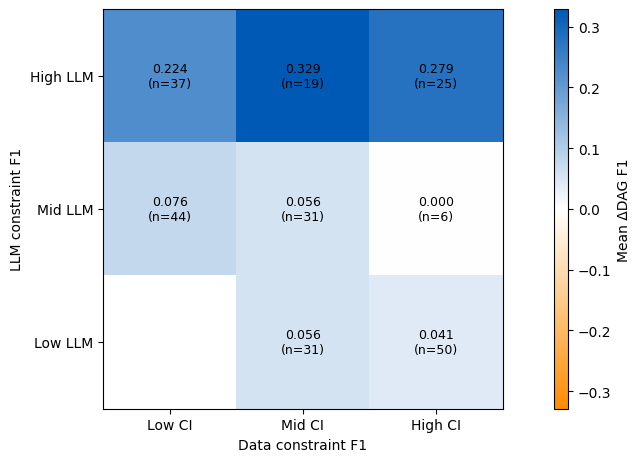

=== Per-dataset heatmaps: dag_F1 ===


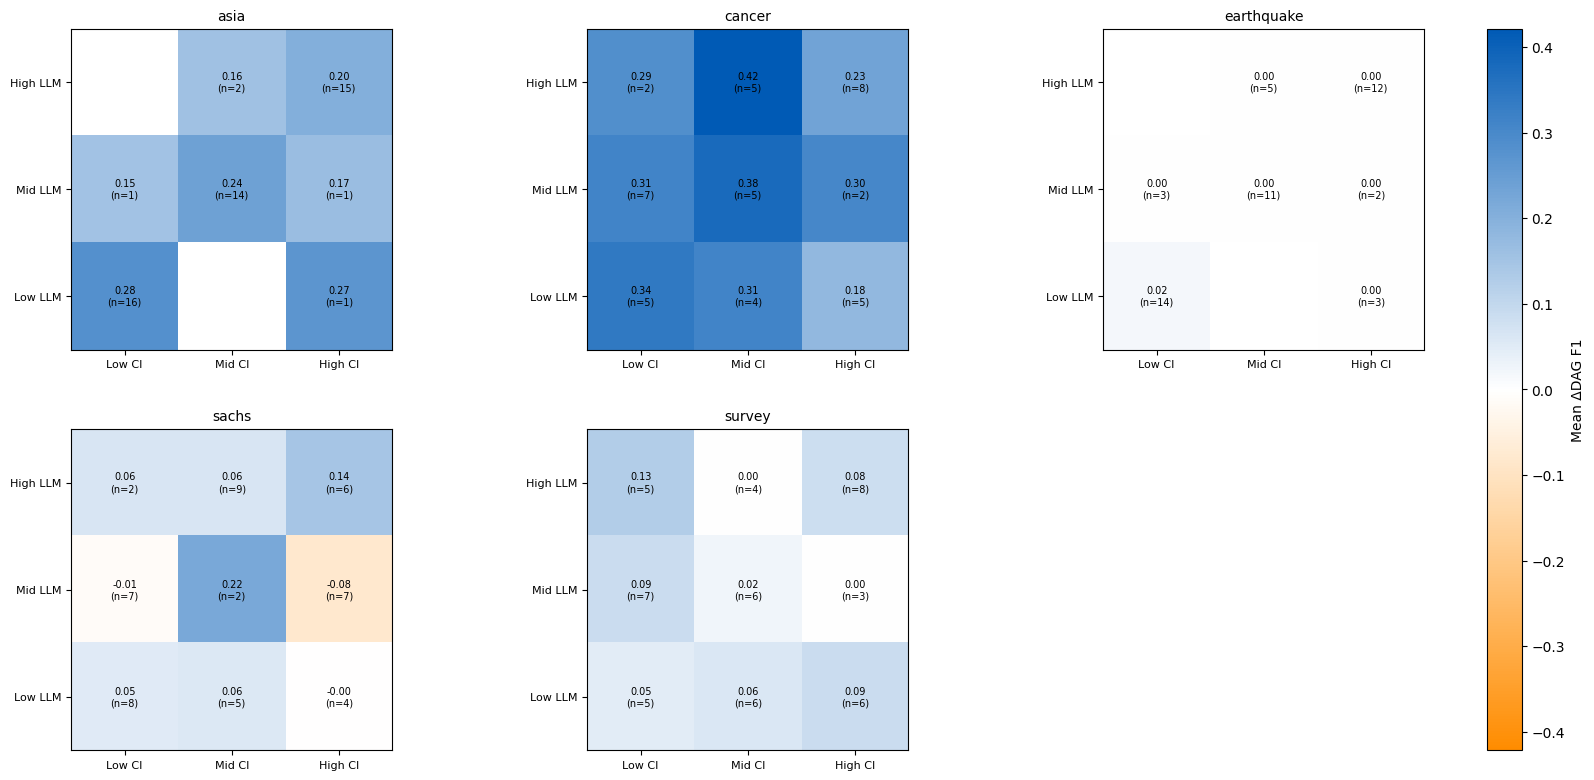


=== Aggregated heatmap: dag_shd ===


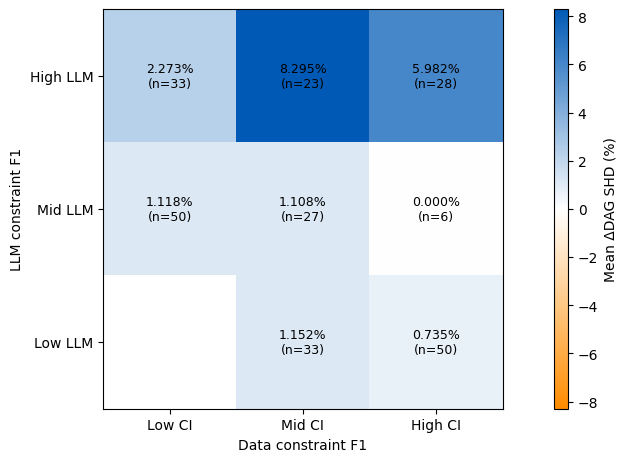

=== Per-dataset heatmaps: dag_shd ===


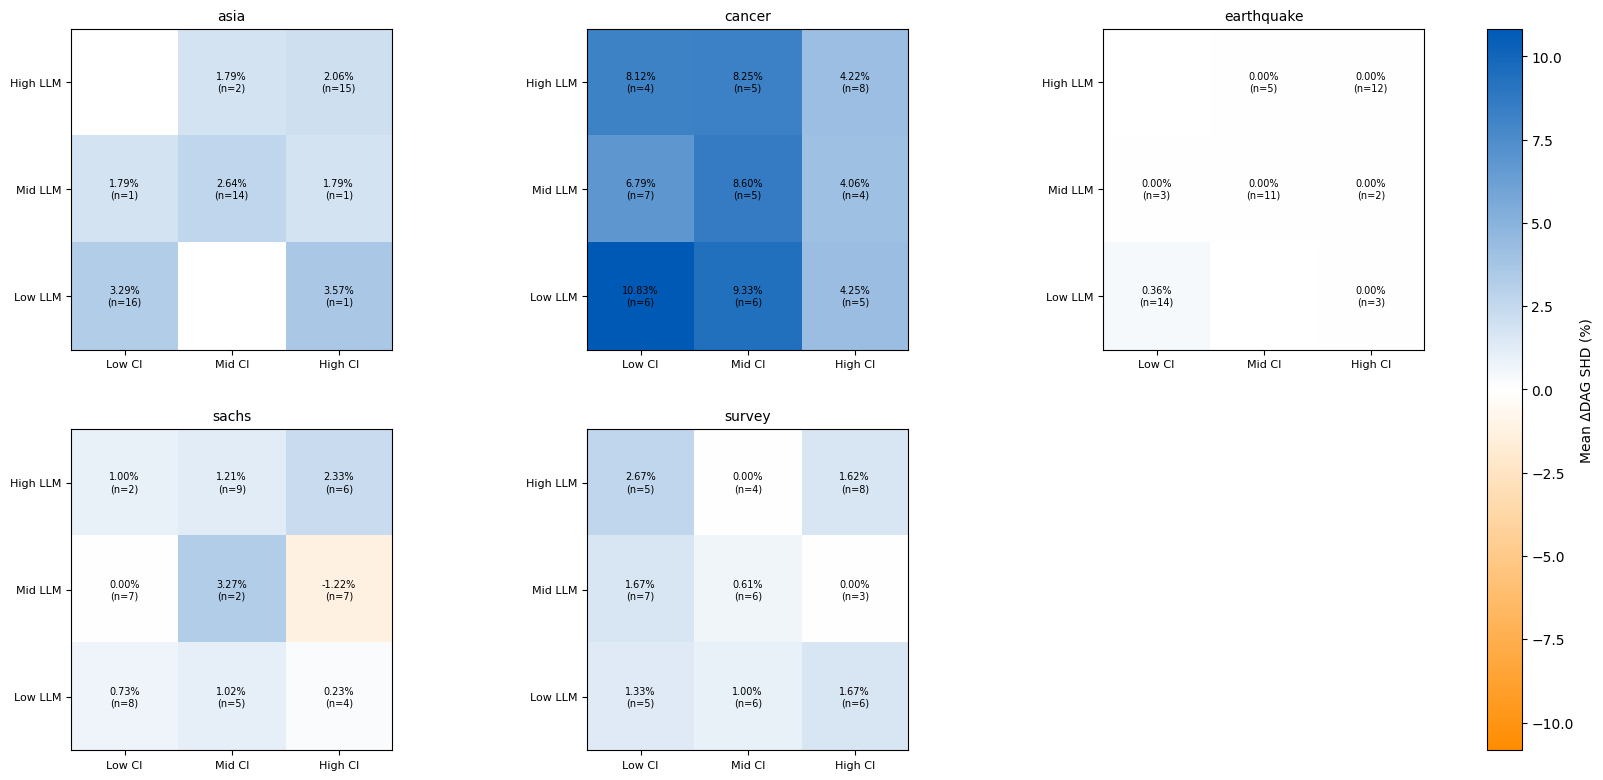


=== Aggregated heatmap: dag_sid ===


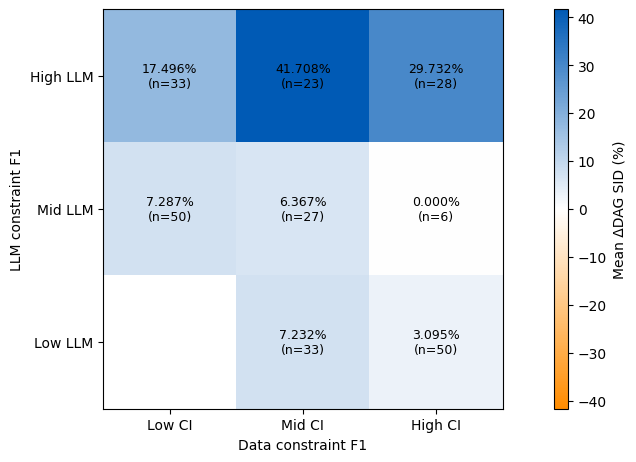

=== Per-dataset heatmaps: dag_sid ===


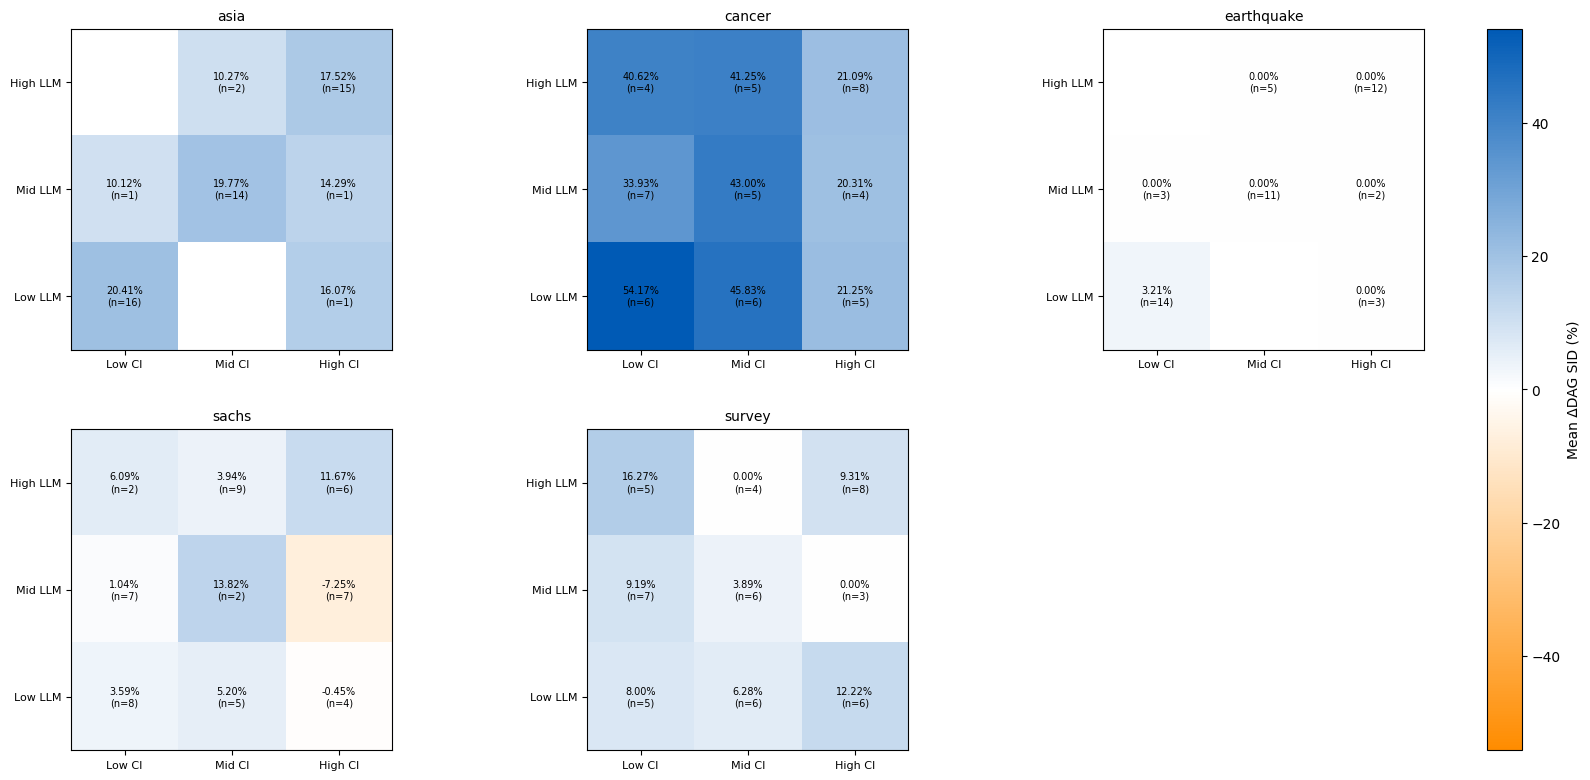


=== Aggregated heatmap: cpdag_F1 ===


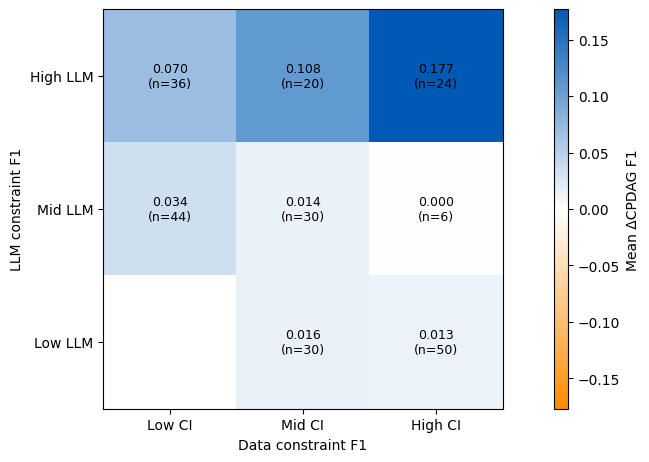

=== Per-dataset heatmaps: cpdag_F1 ===


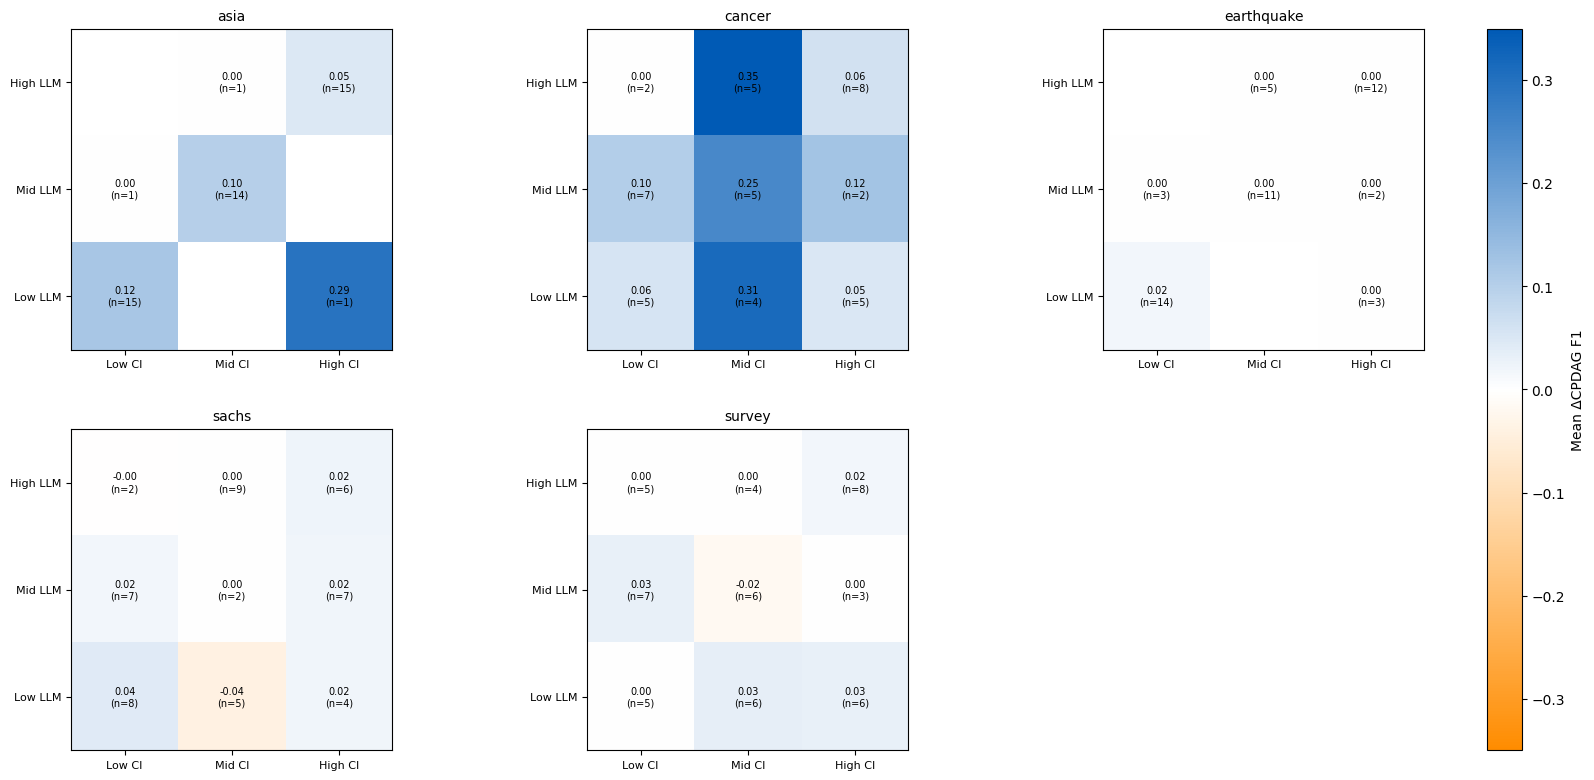


=== Aggregated heatmap: cpdag_shd ===


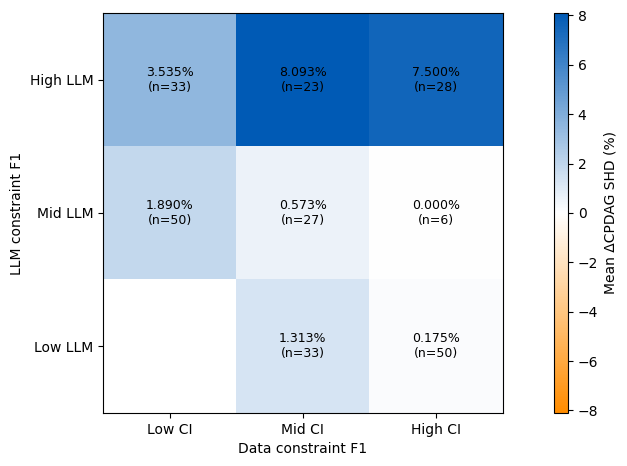

=== Per-dataset heatmaps: cpdag_shd ===


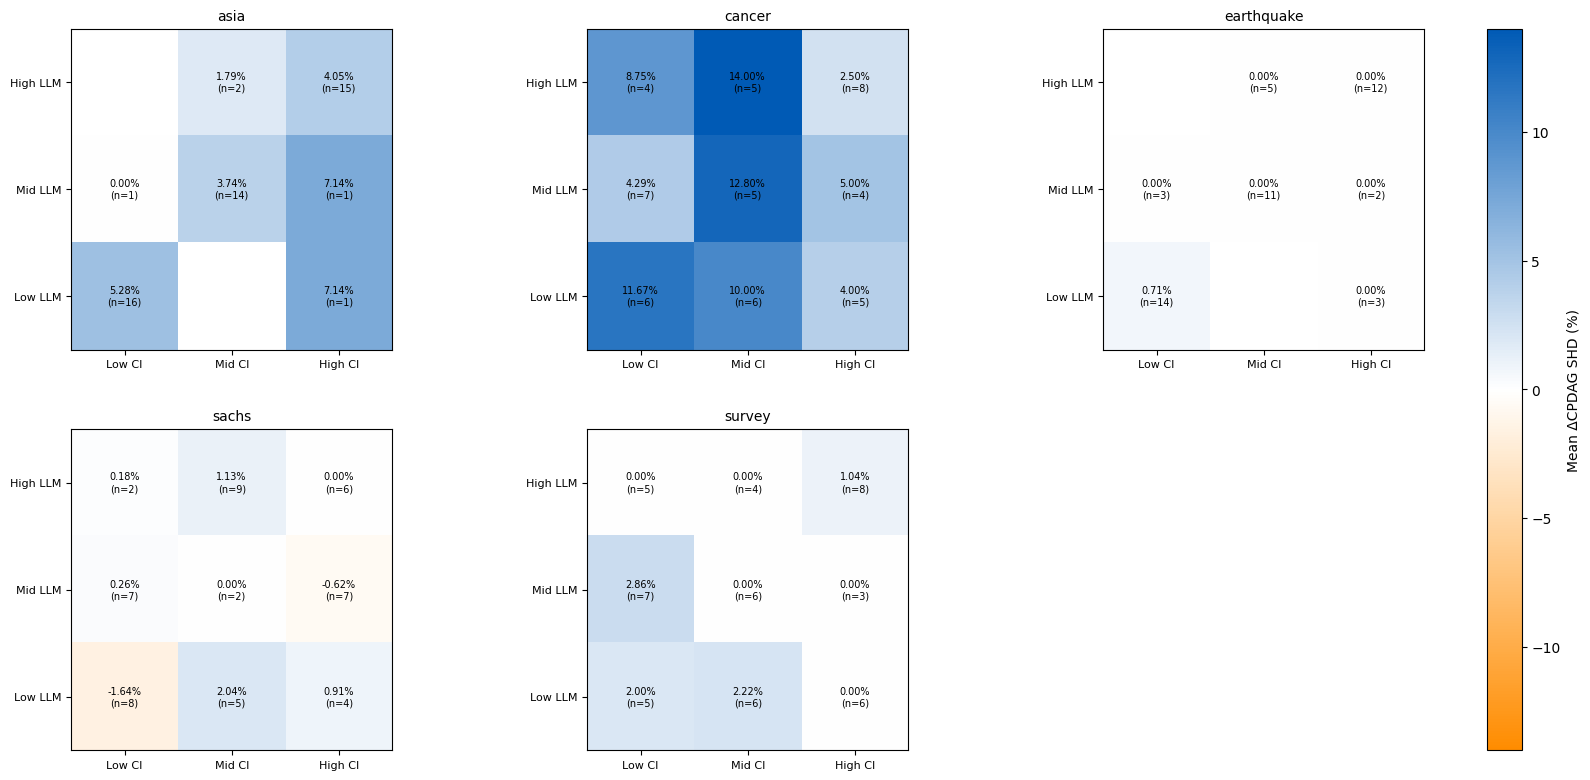


=== Aggregated heatmap: cpdag_sid_avg ===


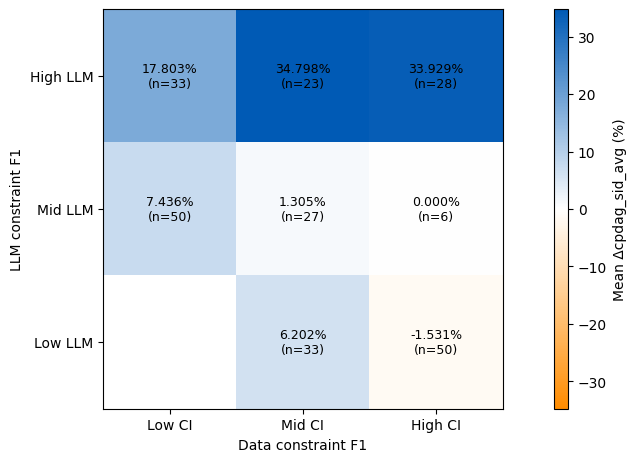

=== Per-dataset heatmaps: cpdag_sid_avg ===


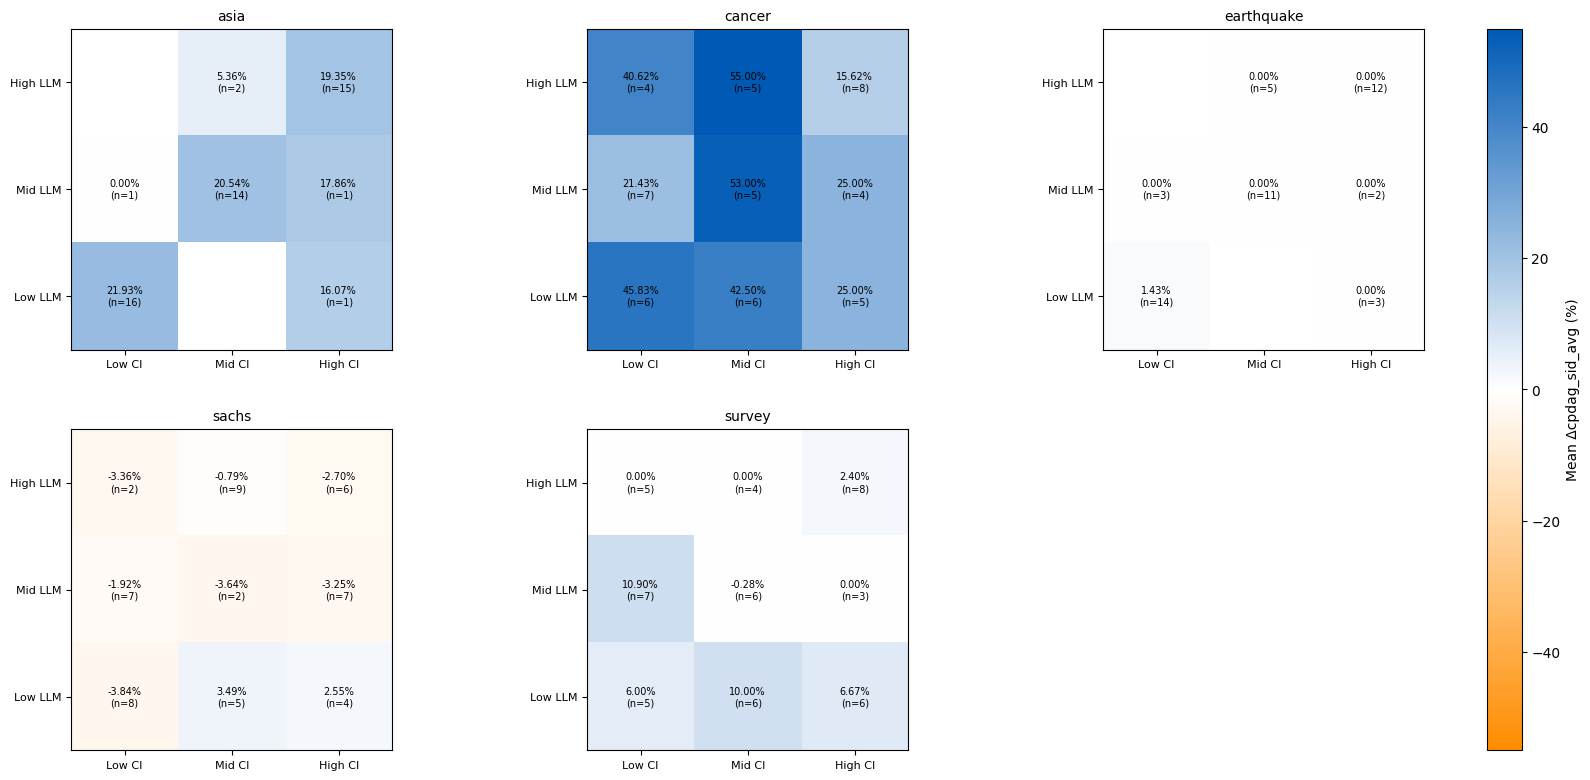

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import math

INPATH = "../results/merged_bnlearn 1.csv"
df = pd.read_csv(INPATH)

# Build LLM quality overall
if "prior_forbidden_F1" in df.columns and "prior_required_F1" in df.columns:
    df["prior_overall_F1"] = df[["prior_forbidden_F1","prior_required_F1"]].mean(axis=1)
LLM_COL = next((c for c in ["prior_overall_F1","AP_F1","prior_required_F1","prior_forbidden_F1","prior_forbidden_Precision","AP"] if c in df.columns), None)

# Build robust CI quality per row:
def row_ci_quality(row):
    # preferred
    if pd.notna(row.get("CIT_F1")):
        return row["CIT_F1"]
    p = row.get("CIT_Precision"); r = row.get("CIT_Recall")
    if pd.notna(p) and pd.notna(r) and (p+r)>0:
        return 2*p*r/(p+r)
    if pd.notna(r):
        return r
    if pd.notna(p):
        return p
    return np.nan

df["CIQ"] = df.apply(row_ci_quality, axis=1)
# Clip to [0,1]
df["CIQ"] = pd.to_numeric(df["CIQ"], errors="coerce").clip(0,1)

# Average per dataset,seed,impl
metrics_all = [c for c in ["dag_F1","dag_shd","dag_sid","cpdag_F1","cpdag_shd","cpdag_sid_low","cpdag_sid_high"] if c in df.columns]
keep = ["dataset","seed","impl","num_nodes","CIQ",LLM_COL] + metrics_all
avg = (df[keep]
       .groupby(["dataset","seed","impl"], as_index=False)
       .mean(numeric_only=True))

# Pivot org/new
org = (avg[avg["impl"]=="org"].drop(columns=["impl"]).rename(columns={"CIQ":"ci_quality"}))
new = (avg[avg["impl"]=="new"].drop(columns=["impl"]).rename(columns={"CIQ":"ci_quality_new", LLM_COL:"llm_quality"}))
merged = pd.merge(new, org, on=["dataset","seed"], how="inner", suffixes=("_new","_org"))
merged["n_nodes"] = merged["num_nodes_new"].fillna(merged["num_nodes_org"])

# DAG F1 run table
def make_run(metric, higher_is_better, graph_kind):
    new_col = f"{metric}_new"; org_col = f"{metric}_org"
    if new_col not in merged.columns or org_col not in merged.columns:
        return None, ""
    m = merged[["dataset","seed","n_nodes","ci_quality","llm_quality",new_col,org_col]].copy()
    m = m.rename(columns={new_col:"comb", org_col:"ci"})
    if higher_is_better:
        m["delta"] = m["comb"] - m["ci"]; units = ""
    else:
        n = m["n_nodes"].astype(float)
        capacity = n*(n-1) if graph_kind=="dag" else n*(n-1)/2.0
        capacity = capacity.replace(0, np.nan)
        m["delta"] = 100.0*(m["ci"] - m["comb"])/capacity; units = "%"
    m["ci_quality"] = pd.to_numeric(m["ci_quality"], errors="coerce").clip(0,1)
    m["llm_quality"] = pd.to_numeric(m["llm_quality"], errors="coerce").clip(0,1)
    return m, units

m_dagF1, u = make_run("dag_F1", True, "dag")

# Check asia availability now
asia = m_dagF1[m_dagF1["dataset"]=="asia"]
counts = {
    "rows": len(asia),
    "non_nan_CI": asia["ci_quality"].notna().sum(),
    "non_nan_LLM": asia["llm_quality"].notna().sum(),
    "unique_CI": len(asia["ci_quality"].dropna().unique()),
    "unique_LLM": len(asia["llm_quality"].dropna().unique())
}
counts


# Build robust run tables for all metrics with the fixed CI quality

def cmap_blue_good_orange_bad():
    return LinearSegmentedColormap.from_list(
        "good_blue_bad_orange",
        [(255/255,140/255,0/255), (1,1,1), (0/255,90/255,181/255)],
        N=256
    )

def tie_safe_qcut(series, labels):
    s = pd.to_numeric(series, errors="coerce")
    ranks = s.rank(method="first")
    norm = ranks / (ranks.max() if ranks.max() else 1)
    # If all values are identical, qcut will still split by rank evenly.
    return pd.qcut(norm, q=len(labels), labels=labels)

def compute_grid_q3(df_m):
    ci_labels  = ["Low CI","Mid CI","High CI"]
    llm_labels = ["Low LLM","Mid LLM","High LLM"]
    m = df_m.dropna(subset=["ci_quality","llm_quality","delta"]).copy()
    if m.empty:
        return np.full((3,3,np.nan)).squeeze(), np.zeros((3,3), dtype=int), llm_labels[::-1], ci_labels
    m["ci_bin"]  = tie_safe_qcut(m["ci_quality"],  ci_labels)
    m["llm_bin"] = tie_safe_qcut(m["llm_quality"], llm_labels)
    rows = list(m["llm_bin"].cat.categories)[::-1]
    cols = list(m["ci_bin"].cat.categories)
    means = np.full((3,3), np.nan); counts = np.zeros((3,3), dtype=int)
    for i, rlab in enumerate(rows):
        for j, clab in enumerate(cols):
            vals = m.loc[(m["llm_bin"]==rlab) & (m["ci_bin"]==clab), "delta"].astype(float)
            if len(vals) > 0:
                means[i,j] = float(vals.mean()); counts[i,j] = int(len(vals))
    return means, counts, rows, cols

def plot_agg(m, metric, unit, label):
    means, counts, rows, cols = compute_grid_q3(m)
    vmax = np.nanmax(np.abs(means)) if np.any(~np.isnan(means)) else 1.0
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    fig = plt.figure(figsize=(6.8,5.4))
    ax = fig.add_axes([0.12,0.16,0.66,0.74])
    im = ax.imshow(means, cmap=cmap_blue_good_orange_bad(), norm=norm, aspect="equal")
    ax.set_xticks(range(3)); ax.set_xticklabels(cols, fontsize=10)
    ax.set_yticks(range(3)); ax.set_yticklabels(rows, fontsize=10)
    ax.set_xlabel("Data constraint F1")
    ax.set_ylabel("LLM constraint F1")
    for i in range(3):
        for j in range(3):
            if not np.isnan(means[i,j]):
                ax.text(j,i,f"{means[i,j]:.3f}{unit}\n(n={counts[i,j]})", ha="center", va="center", fontsize=9)
    cax = fig.add_axes([0.82,0.16,0.02,0.74]); cb = fig.colorbar(im, cax=cax)
    cb.set_label(f"Mean Δ{label}{(' ('+unit+')') if unit else ''}")
    # fig.suptitle(f"{metric} — aggregated", fontsize=14, y=0.995)
    plt.show()

def plot_by_dataset(m, metric, unit, label):
    ds = sorted(m["dataset"].unique())
    n = len(ds); ncols=3; nrows=math.ceil(n/ncols)
    fig = plt.figure(figsize=(5.0*ncols+2.2, 4.4*nrows))
    left, right, top, bottom = 0.05, 0.11, 0.08, 0.10
    wspace, hspace = 0.06, 0.09
    grid_w = 1 - left - right; grid_h = 1 - top - bottom
    cell_w = (grid_w - (ncols-1)*wspace)/ncols; cell_h = (grid_h - (nrows-1)*hspace)/nrows

    panels = []; vmax=0.0
    for d in ds:
        sub = m[m["dataset"]==d]
        means, counts, rows, cols = compute_grid_q3(sub)
        vmax = max(vmax, np.nanmax(np.abs(means)) if np.any(~np.isnan(means)) else 0.0)
        panels.append((d, means, counts, rows, cols))
    if vmax == 0: vmax=1.0
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    cmap = cmap_blue_good_orange_bad()
    for idx, (d, means, counts, rows, cols) in enumerate(panels):
        r = idx//ncols; c = idx % ncols
        ax = fig.add_axes([left + c*(cell_w+wspace), 1 - top - (r+1)*cell_h - r*hspace, cell_w, cell_h])
        im = ax.imshow(means, cmap=cmap, norm=norm, aspect="equal")
        ax.set_xticks(range(3)); ax.set_xticklabels(cols, fontsize=8)
        ax.set_yticks(range(3)); ax.set_yticklabels(rows, fontsize=8)
        ax.set_title(d, fontsize=10)
        for i in range(3):
            for j in range(3):
                if not np.isnan(means[i,j]):
                    ax.text(j,i,f"{means[i,j]:.2f}{unit}\n(n={counts[i,j]})", ha="center", va="center", fontsize=7)
    cax = fig.add_axes([1-right+0.01, bottom, 0.02, grid_h])
    cb = fig.colorbar(im, cax=cax); cb.set_label(f"Mean Δ{label}{(' ('+unit+')') if unit else ''}")
    # fig.suptitle(f"{metric} — per dataset (Low/Mid/High by rank)", fontsize=15, y=0.995)
    plt.show()

# Build run dict for all metrics
def all_runs(merged):
    out = {}; units = {}
    specs = [("dag_F1", True, "dag"),
             ("dag_shd", False, "dag"),
             ("dag_sid", False, "dag"),
             ("cpdag_F1", True, "cpdag"),
             ("cpdag_shd", False, "cpdag")]
    if "cpdag_sid_low_new" in merged.columns and "cpdag_sid_high_new" in merged.columns and \
       "cpdag_sid_low_org" in merged.columns and "cpdag_sid_high_org" in merged.columns:
        merged["cpdag_sid_avg_new"] = merged[["cpdag_sid_low_new","cpdag_sid_high_new"]].mean(axis=1)
        merged["cpdag_sid_avg_org"] = merged[["cpdag_sid_low_org","cpdag_sid_high_org"]].mean(axis=1)
        specs.append(("cpdag_sid_avg", False, "cpdag"))
    for metric, hib, kind in specs:
        new_col = f"{metric}_new"; org_col = f"{metric}_org"
        if new_col not in merged.columns or org_col not in merged.columns:
            continue
        m = merged[["dataset","seed","n_nodes","ci_quality","llm_quality",new_col,org_col]].copy()
        m = m.rename(columns={new_col:"comb", org_col:"ci"})
        if hib:
            m["delta"] = m["comb"] - m["ci"]; u=""
        else:
            n = m["n_nodes"].astype(float)
            capacity = n*(n-1) if kind=="dag" else n*(n-1)/2.0
            capacity = capacity.replace(0, np.nan)
            m["delta"] = 100.0*(m["ci"] - m["comb"])/capacity; u="%"
        m["ci_quality"] = pd.to_numeric(m["ci_quality"], errors="coerce").clip(0,1)
        m["llm_quality"] = pd.to_numeric(m["llm_quality"], errors="coerce").clip(0,1)
        out[metric]=m; units[metric]=u
    return out, units

run, units = all_runs(merged)

# # Show for dag_F1 as a check
# plot_agg(run["dag_F1"], "dag_F1", units["dag_F1"])
# plot_by_dataset(run["dag_F1"], "dag_F1", units["dag_F1"])

metric_labels = {
    "dag_F1": "DAG F1",
    "dag_shd": "DAG SHD",
    "dag_sid": "DAG SID",
    "cpdag_F1": "CPDAG F1",
    "cpdag_shd": "CPDAG SHD",
    "cpdag_sid": "CPDAG SID",
}

for metric, m in run.items():
    print(f"\n=== Aggregated heatmap: {metric} ===")
    plot_agg(m, metric, units[metric], metric_labels.get(metric, metric))
    print(f"=== Per-dataset heatmaps: {metric} ===")
    plot_by_dataset(m, metric, units[metric], metric_labels.get(metric, metric))


## CPDAG Results

In [83]:
# Plots by dataset (CPDAG)
if len(cpdag_all):
    methods = [m for m in default_methods if m in cpdag_all['model'].unique()]
    if 'p_SID_low_mean' in cpdag_all:
        cpdag_all['p_SID_low_mean'] = cpdag_all['p_SID_low_mean'].replace(0, 0.03)
    if 'p_SID_high_mean' in cpdag_all:
        cpdag_all['p_SID_high_mean'] = cpdag_all['p_SID_high_mean'].replace(0, 0.03)
    double_bar_chart_plotly(
        cpdag_all, ['p_SID_low','p_SID_high'], names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=24, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_cpdag_SID.html'),
        debug=False, range_y1=[0,6], range_y2=[0,6]
    )
    double_bar_chart_plotly(
        cpdag_all, ['p_shd','F1'], names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_cpdag_SHD_F1.html'),
        debug=False, range_y1=[0,2], range_y2=[0,1.1]
    )
    double_bar_chart_plotly(
        cpdag_all, ['precision','recall'], names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_cpdag_prec_rec.html'),
        debug=False
    )
    bar_chart_plotly(
        cpdag_all, 'nnz', names_dict, colors_dict, methods,
        save_figs=save_figs, font_size=23, output_name=str(REPO_ROOT / 'results/figs/Fig.bn_cpdag_nnz.html'),
        debug=False
    )
else:
    print('No CPDAG results found.')
